In [1]:
using MetaUtils

* https://github.com/mitmath/18S096/blob/master/lectures/other/Syntax%20trees%20in%20Julia.ipynb

In [2]:
# https://github.com/mitmath/18S096/blob/master/lectures/other/Syntax%20trees%20in%20Julia.ipynb

using LightGraphs
using TikzGraphs
using MacroTools

"Return the number of the new vertex"
add_numbered_vertex!(g) = (add_vertex!(g); top = nv(g))

"Convert the current node into a label"
function label(sym) 
    sym == :(^) && return "\\textasciicircum"  # TikzGraphs chokes on ^
    return string("\\texttt{", sym, "}")
end

"""
Traverse the expression and build up the graph g and the set of labels for each node. (These both get modified in place.) `show_call` specifies whether to include `call` nodes in the graph in function calls. Including them represents the Julia AST more precisely, but adds a lot of visual noise to the display.

traverse! returns the number of the vertex at the top of the subexpression.
"""
function traverse!(g, labels, ex, show_call=true)
    top_vertex = add_numbered_vertex!(g)
    start_argument = 1  # which argument to start with

    if !(show_call) && ex.head == :call 
        f = ex.args[1]   # the function name
        push!(labels, label(f))
        start_argument = 2   # drop "call" from tree
    else
        push!(labels, label(ex.head))
    end
    
    for i in start_argument:length(ex.args)
        if isa(ex.args[i], Expr)
            child = traverse!(g, labels, ex.args[i], show_call)
            add_edge!(g, top_vertex, child)
        else
            n = add_numbered_vertex!(g)
            add_edge!(g, top_vertex, n)
            push!(labels, label(ex.args[i]))
        end
    end
    
    return top_vertex
end

function make_graph(ex::Expr, show_call=false)
    # https://github.com/FluxML/MacroTools.jl/blob/master/src/utils.jl#L87
    ex = MacroTools.striplines(ex)
    g = Graph()
    labels = String[]
    traverse!(g, labels, ex, show_call)
    return g, labels
end

function draw_syntax_tree(ex::Expr, show_call=false)
    TikzGraphs.plot(make_graph(ex::Expr, show_call)...)
end

macro tree(ex::Expr)
    draw_syntax_tree(ex)
end

macro tree_with_call(ex::Expr)
    draw_syntax_tree(ex, true)
end

@tree_with_call (macro with 1 method)

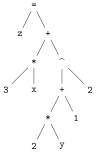

In [3]:
t = @tree z = 3x + (2y+1)^2

In [4]:
t.data

"\\graph [layered layout, ] {\n1/\"\\texttt{=}\" [],\n2/\"\\texttt{z}\" [],\n3/\"\\texttt{+}\" [],\n4/\"\\texttt{*}\" [],\n5/\"\\texttt{3}\" [],\n6/\"\\texttt{x}\" [],\n7/\"\\textasciicircum\" [],\n8/\"\\texttt{+}\" [],\n9/\"\\texttt{*}\" [],\n10/\"\\texttt{2}\" [],\n11/\"\\texttt{y}\" [],\n12/\"\\texttt{1}\" [],\n13/\"\\texttt{2}\" [],\n;\n1 -- [,] 2;\n1 -- [,] 3;\n3 -- [,] 4;\n3 -- [,] 7;\n4 -- [,] 5;\n4 -- [,] 6;\n7 -- [,] 8;\n7 -- [,] 13;\n8 -- [,] 9;\n8 -- [,] 12;\n9 -- [,] 10;\n9 -- [,] 11;\n};\n"

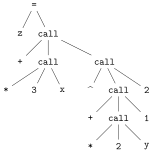

In [5]:
@tree_with_call z = 3x + (2y+1)^2

In [6]:
@show_tree z = 3x + (2y+1)^2

Expr(:(=))
├─ :z
└─ Expr(:call)
   ├─ :+
   ├─ Expr(:call)
   │  ├─ :*
   │  ├─ 3
   │  └─ :x
   └─ Expr(:call)
      ├─ :^
      ├─ Expr(:call)
      │  ├─ :+
      │  ├─ Expr(:call)
      │  │  ├─ :*
      │  │  ├─ 2
      │  │  └─ :y
      │  └─ 1
      └─ 2


In [7]:
@show_texpr z = 3x + (2y+1)^2

(:(=), :z, 
    (:call, :+, 
        (:call, :*, 3, :x), 
        (:call, :^, 
            (:call, :+, 
                (:call, :*, 2, :y), 1), 2)))

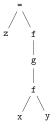

In [8]:
@tree z = f(g(f(x, y)))

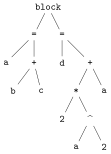

In [9]:
@tree begin
    a = b + c
    d = 2a^2 + a
end

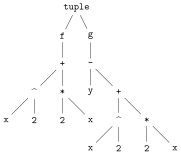

In [10]:
@tree (f(x^2 + 2x), g(y - (x^2 + 2x)))

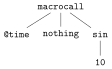

In [11]:
@tree @time sin(10)

In [12]:
@show_tree @time sin(10)

Expr(:macrocall)
├─ Symbol("@time")
├─ :(#= In[12]:1 =#)
└─ Expr(:call)
   ├─ :sin
   └─ 10


In [13]:
@show_texpr @time sin(10)

(:macrocall, Symbol("@time"), LineNumberNode(1, Symbol("In[13]")), 
    (:call, :sin, 10))

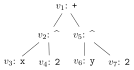

In [14]:
g, labels = make_graph(:(x^2 + y^2))

for i in 1:length(labels)
    labels[i] = string("\$v_", i, "\$: \$", labels[i], "\$")
end

TikzGraphs.plot(g, labels)

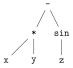

In [15]:
@tree x*y - sin(z)

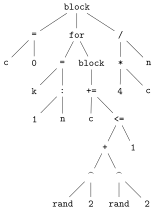

In [16]:
@tree (c = 0; for k in 1:n c += rand()^2 + rand()^2 <= 1 end; 4c/n)

In [17]:
@show_tree (c = 0; for k in 1:n c += rand()^2 + rand()^2 ≤ 1 end; 4c/n)

Expr(:block)
├─ Expr(:(=))
│  ├─ :c
│  └─ 0
├─ Expr(:for)
│  ├─ Expr(:(=))
│  │  ├─ :k
│  │  └─ Expr(:call)
│  │     ├─ :(:)
│  │     ├─ 1
│  │     └─ :n
│  └─ Expr(:block)
│     └─ Expr(:+=)
│        ├─ :c
│        └─ Expr(:call)
│           ├─ :≤
│           ├─ Expr(:call)
│           │  ├─ :+
│           │  ├─ Expr(:call)
│           │  │  ├─ :^
│           │  │  ├─ Expr(:call)
│           │  │  │  └─ :rand
│           │  │  └─ 2
│           │  └─ Expr(:call)
│           │     ├─ :^
│           │     ├─ Expr(:call)
│           │     │  └─ :rand
│           │     └─ 2
│           └─ 1
└─ Expr(:call)
   ├─ :/
   ├─ Expr(:call)
   │  ├─ :*
   │  ├─ 4
   │  └─ :c
   └─ :n


In [18]:
@show_texpr (c = 0; for k in 1:n c += rand()^2 + rand()^2 ≤ 1 end; 4c/n)

(:block, 
    (:(=), :c, 0), 
    (:for, 
        (:(=), :k, 
            (:call, :(:), 1, :n)), 
        (:block, 
            (:+=, :c, 
                (:call, :≤, 
                    (:call, :+, 
                        (:call, :^, 
                            (:call, :rand), 2), 
                        (:call, :^, 
                            (:call, :rand), 2)), 1)))), 
    (:call, :/, 
        (:call, :*, 4, :c), :n))